In [22]:
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T

import torch
import torch.nn as nn
import torch 
from torch_geometric.nn import NNConv
import torch.nn.functional as F
# from test_model import Encoder

In [6]:
# transform = T.Compose([MyTransform(), Complete(), T.Distance(norm=False)])

data = QM9(root='./practice_data', transform=None)

In [7]:
"""
each batch is considered a hugh graph with many nodes and edges,
in EGNN, they introduce the concept of l2 distance between nodes, 
yet I am not including this (probably not) for now. 


"""
dataloader = DataLoader(data, batch_size=32, shuffle=True) 
for i , x in enumerate(dataloader):
    print(x)
    if i > 20: 
        break
    


DataBatch(x=[552, 11], edge_index=[2, 1132], edge_attr=[1132, 4], y=[32, 19], pos=[552, 3], idx=[32], name=[32], z=[552], batch=[552], ptr=[33])
DataBatch(x=[592, 11], edge_index=[2, 1224], edge_attr=[1224, 4], y=[32, 19], pos=[592, 3], idx=[32], name=[32], z=[592], batch=[592], ptr=[33])
DataBatch(x=[562, 11], edge_index=[2, 1158], edge_attr=[1158, 4], y=[32, 19], pos=[562, 3], idx=[32], name=[32], z=[562], batch=[562], ptr=[33])
DataBatch(x=[569, 11], edge_index=[2, 1176], edge_attr=[1176, 4], y=[32, 19], pos=[569, 3], idx=[32], name=[32], z=[569], batch=[569], ptr=[33])
DataBatch(x=[557, 11], edge_index=[2, 1156], edge_attr=[1156, 4], y=[32, 19], pos=[557, 3], idx=[32], name=[32], z=[557], batch=[557], ptr=[33])
DataBatch(x=[571, 11], edge_index=[2, 1182], edge_attr=[1182, 4], y=[32, 19], pos=[571, 3], idx=[32], name=[32], z=[571], batch=[571], ptr=[33])
DataBatch(x=[598, 11], edge_index=[2, 1234], edge_attr=[1234, 4], y=[32, 19], pos=[598, 3], idx=[32], name=[32], z=[598], batch=[5

In [12]:
dummy = next(iter(dataloader))

In [14]:
print(dummy)
edg = dummy.edge_index
print(dummy.edge_index)

DataBatch(x=[567, 11], edge_index=[2, 1166], edge_attr=[1166, 4], y=[32, 19], pos=[567, 3], idx=[32], name=[32], z=[567], batch=[567], ptr=[33])
tensor([[  0,   0,   0,  ..., 564, 565, 566],
        [  1,   9,  10,  ..., 553, 554, 555]])


# PYG 

- [qm9 example](https://github.com/pyg-team/pytorch_geometric/blob/master/examples/qm9_nn_conv.py)


## Node Embedding 

#### Why Use Node Embeddings ?
Node embeddings have a number of advantages over other methods for learning node representations. First, node embeddings can be trained using standard neural network optimization methods. Second, node embeddings can be trained on graphs with arbitrary structure. Finally, node embeddings can be used to represent nodes in multiple graphs simultaneously.


#### How are Node Embeddings Learned ?
Node embeddings are learned by training a neural network to map nodes in a graph to low-dimensional vectors. The network is trained using a loss function that encourages the vectors for similar nodes to be close together and the vectors for dissimilar nodes to be far apart.


#### The process of Node embedding 
The neural network takes the graph as input and applies a series of operations to transform the node features and capture the relationships between nodes. These operations can include ***graph convolutional layers, pooling layers, or attention mechanisms***, depending on the specific architecture of the neural network.





Resource:
- [node embedding tutorial](https://medium.com/the-modern-scientist/graph-neural-networks-series-part-3-node-embedding-36613cc967d5)



In [12]:
struc = [NNConv(in_channels=3, out_channels=3, nn =edge_attr_nn, aggr='add')
             for _ in range(3)]
gcl = nn.Sequential(
                *struc
            )
out = lin0(dummy.x)
out = gcl(out, dummy.edge_index, dummy.edge_attr)

TypeError: Sequential.forward() takes 2 positional arguments but 4 were given

In [23]:

# edge_attr_nn = nn.Sequential(
#             nn.Linear(4, 64), 
#             nn.ReLU(),
#             nn.Linear(64, 3*3)
#             ) # NN convolution block for edge conditioned convolution 
# lin0 = torch.nn.Linear(11, 3)
# nconv = NNConv(in_channels=3, out_channels=3, nn =edge_attr_nn, aggr='add')
# out = lin0(dummy.x)
# for i in range(3):
#     out = nconv(out, dummy.edge_index, dummy.edge_attr)
# print(out.size())


torch.Size([567, 3])


# Encoder

### GCN (Graph Convolutional Layer)

GCN consist of the convolution operations to edges and nodes features, the technique is mainly used to embed the molecules (graph representation) to an embedded space. There consists of two models, ***1) node mlp*** and ***2) edge mlp***. 

*** *Following is my own understanding* ***


Inside the GCL, the initial $h_0$ is atoms features, including the atom types and charges (concated tensor). Are edge features the adjacency matrix?? In addition to the edge features, edge attributes (how do i put adj matrix inside my code). 


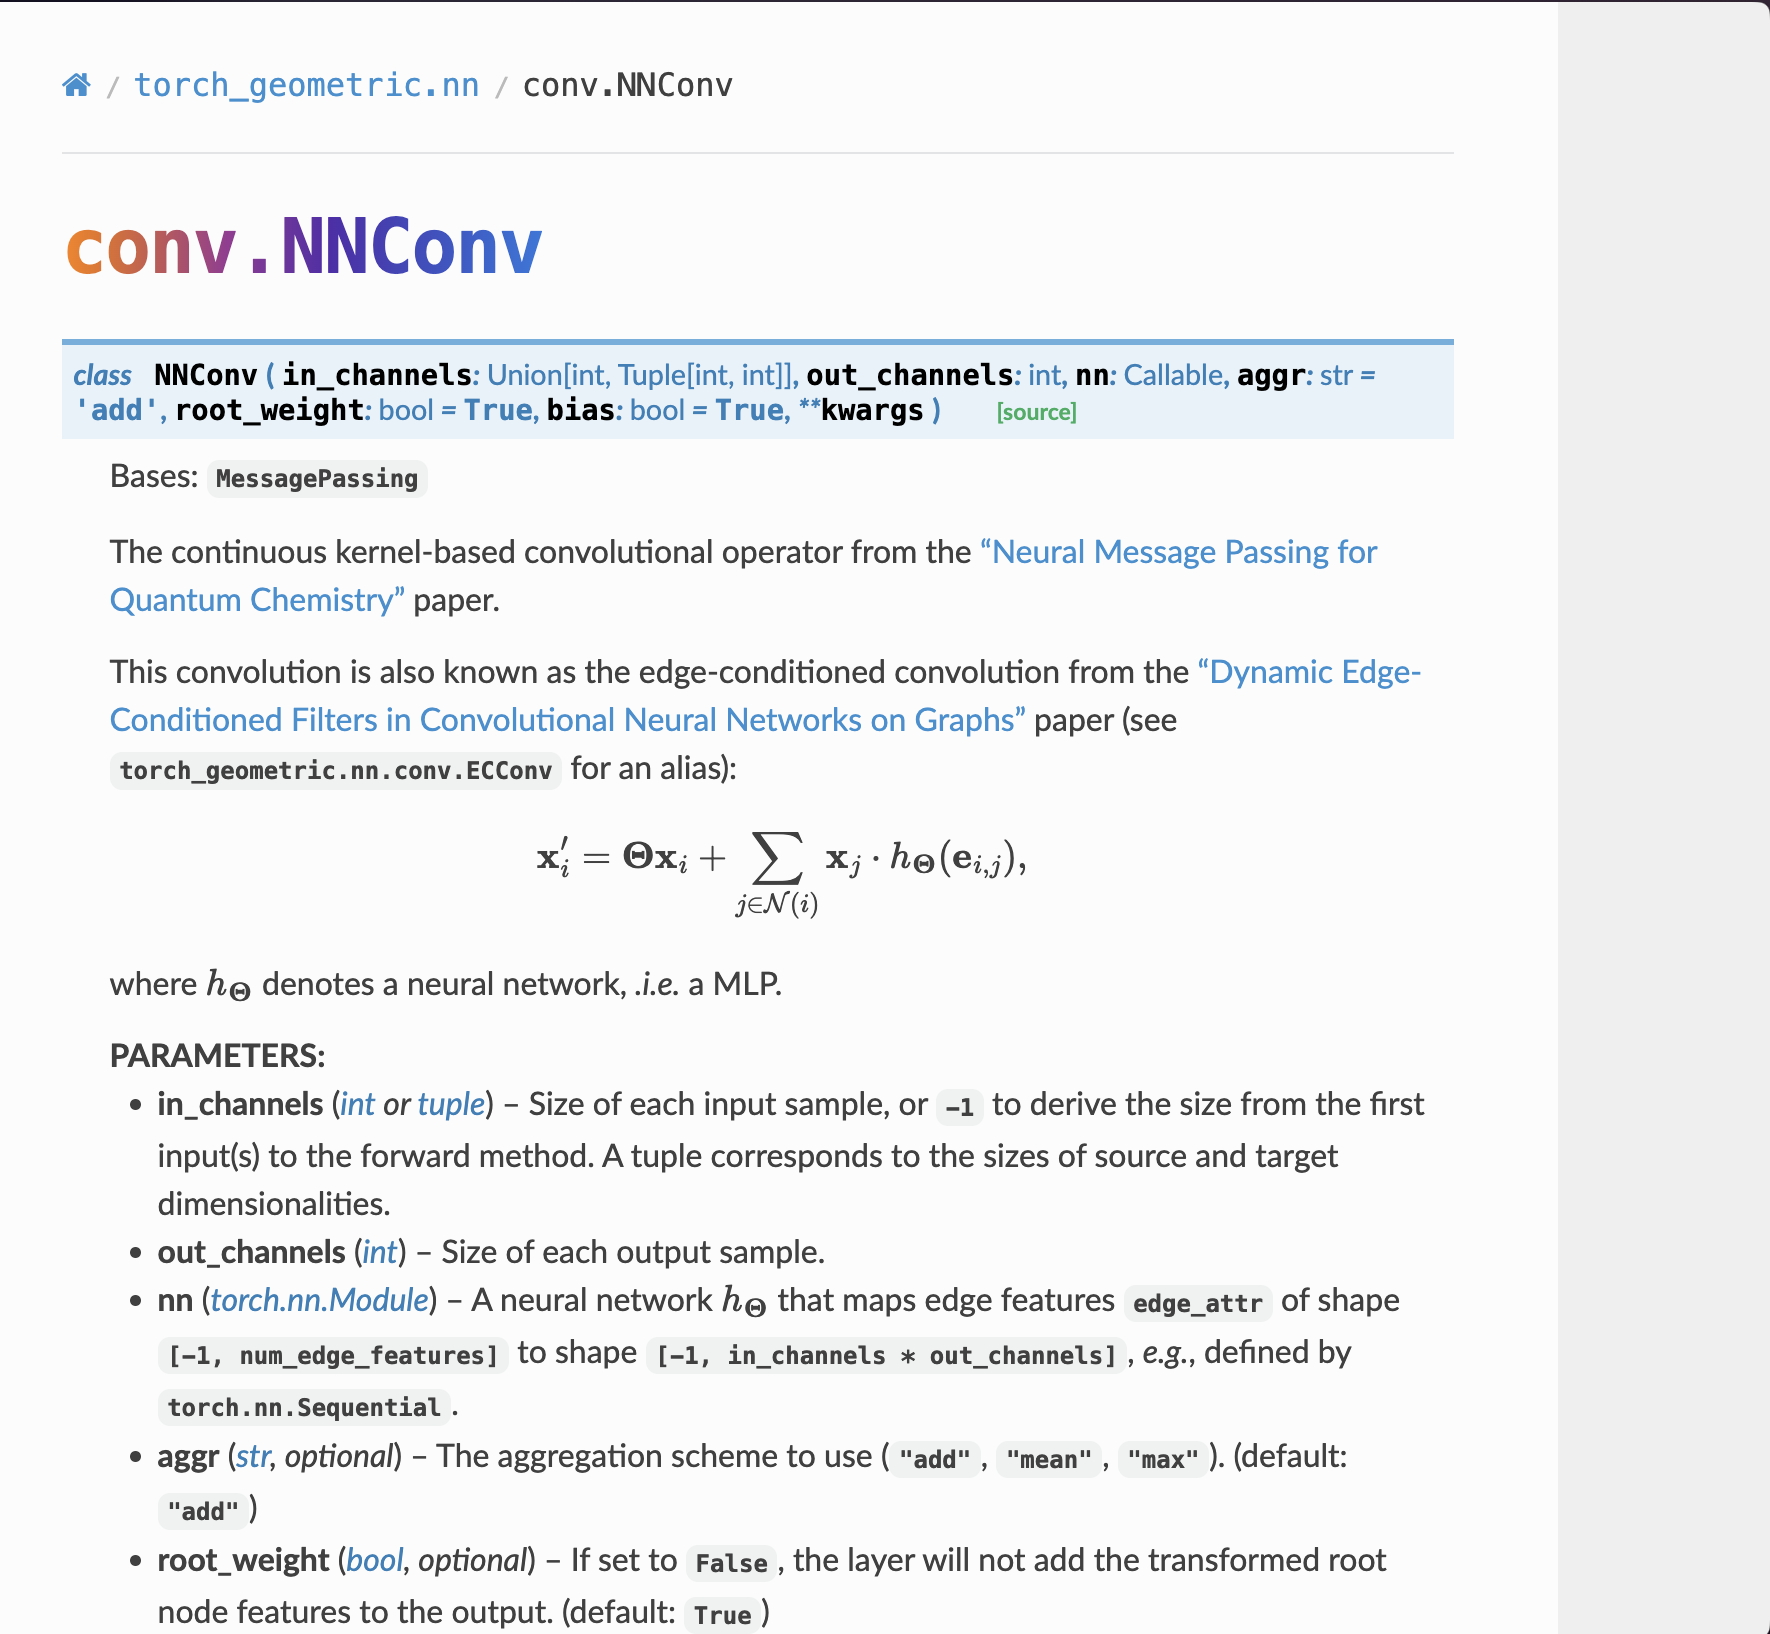

# PyG NNConvolution 

Edge conditioned convolution 

input: nodes features (embedding): $(|V|, N_{feat})$
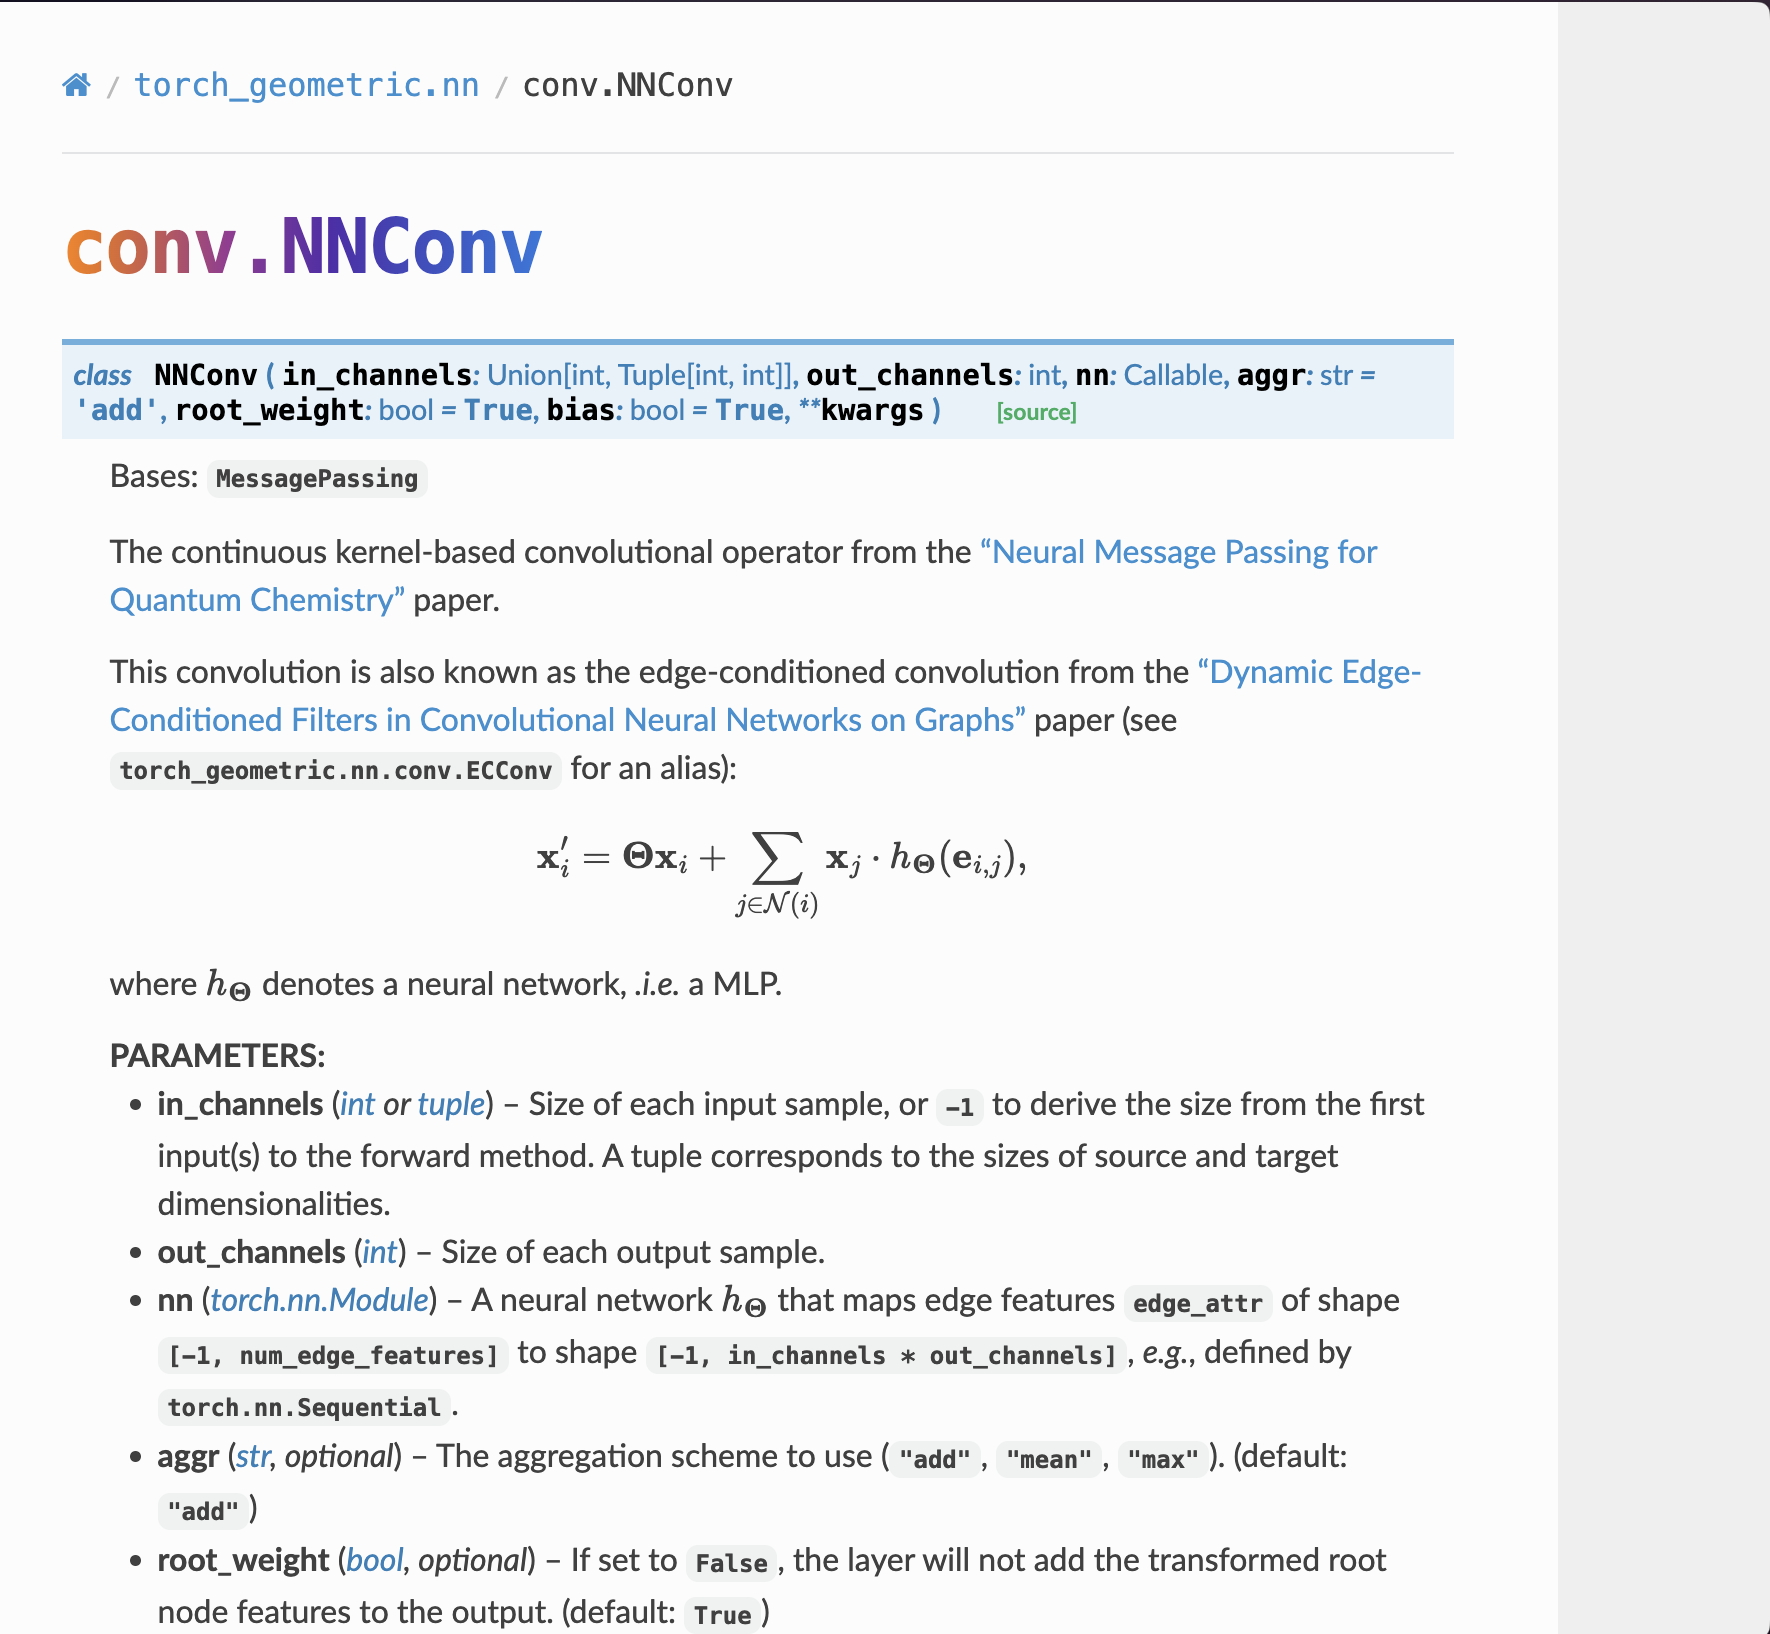

In [32]:
class GraphConv(nn.Module):
    def __init__(self, in_channels, out_channels, nn_model, aggr, activation=nn.SiLU()):
        super(GraphConv, self).__init__()
        self.activation = activation
        # self.gcl = nn.Sequential(
        #     NNConv(in_channels, out_channels, nn_model, aggr), # graph convolution 
        #     self.activation, 
        #     nn.Linear(out_channels, out_channels)
        # )
        self.gc = NNConv(in_channels, out_channels, nn_model, aggr)
        self.lin = nn.Linear(out_channels, out_channels)
    def forward(self, x, edge_index, edge_attr):
        x = self.gc(x, edge_index, edge_attr)
        x = self.activation(x)
        x = self.lin(x)
        return x

class Encoder(nn.Module):
    def __init__(self, n_feat_in, hidden_dim, latent_dim, n_layers, activation= nn.SiLU()):
        super(Encoder, self).__init__()
        # self.device = device
        self.n_layers = n_layers
        self.act = activation
        self.embedding = nn.Linear(n_feat_in, hidden_dim) # initialize the embedding layer
        self.embedding_out = nn.Linear(hidden_dim, latent_dim) # output embedding layer (latent space)
        
        # self.nn is for edge features
        # in_shape = (-1, num_edge_features) -> out_shape = (-1, hidden_dim*hidden_dim)
        self.edge_attr_nn = nn.Sequential(
            nn.Linear(4, hidden_dim), 
            self.act,
            nn.Linear(hidden_dim, hidden_dim*hidden_dim)
            ) # NN convolution block for edge conditioned convolution 
        
    
        ### Encoder 
        # graph convolution layers

        # NNConv(in_channels=hidden_dim, out_channels=hidden_dim, nn =self.edge_attr_nn, aggr='add')
        for i in range(self.n_layers):
            # edge conditioned convolution (input is node features and conditioned by edge)
            print("add gcl_%d" % i)
            # self.conv = NNConv(in_channels=hidden_dim, out_channels=hidden_dim, nn =self.edge_attr_nn, aggr='add')
            self.add_module("gcl_%d" % i, 
                GraphConv(in_channels=hidden_dim, out_channels=hidden_dim, nn_model =self.edge_attr_nn, aggr='add', activation=self.act)
                ) # message passing layer
            
        # Pooling layers
        """
        Basically the parameters
        
        graph convolution:
        - forward pass: (x:nodes embedding, edge_index: edge index, edge_attr: edge attributes)
        
        """


    def forward(self, x, edge_index, edge_attr=None, batch=None):
        """_summary_

        Args:
            x (_type_): node features
            edge_index (_type_): edge index matrix, shape = [2, num_edges]
            edge_attr (_type_): edge attributes, default None


        Returns:
            h: graph latent representation
        """
        h = self.embedding(x)
        print("initial h:", h.shape)
        
        for i in range(self.n_layers):
            print("running gcl_%d" % i)
            h = self._modules["gcl_%d" % i](h, edge_index, edge_attr)
            print("h in the loop:", h.shape)
        
        out = F.relu(self.embedding_out(h)) # first try the one with non-lin activation 
        
        # out = F.relu(self.lin1(out))
        # out = self.lin2(out)/
        return out
    
    class Net(torch.nn.Module):
        def __init__(self):
            super().__init__()
            self.lin0 = torch.nn.Linear(dataset.num_features, dim)

            nn = Sequential(Linear(5, 128), ReLU(), Linear(128, dim * dim))
            self.conv = NNConv(dim, dim, nn, aggr='mean')
            self.gru = GRU(dim, dim)

            self.set2set = Set2Set(dim, processing_steps=3)
            self.lin1 = torch.nn.Linear(2 * dim, dim)
            self.lin2 = torch.nn.Linear(dim, 1)

        def forward(self, data):
            out = F.relu(self.lin0(data.x))
            h = out.unsqueeze(0)

            for i in range(3):
                m = F.relu(self.conv(out, data.edge_index, data.edge_attr))
                out, h = self.gru(m.unsqueeze(0), h)
                out = out.squeeze(0)

            out = self.set2set(out, data.batch)
            out = F.relu(self.lin1(out))
            out = self.lin2(out)
            return out.view(-1)

In [33]:

from tqdm import tqdm 
import torch 
# try the customized pyg model 
hidden_dim = 64 # hidden dimension
n_feat_out = 7 # output latent embedding shape
n_layers = 4
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
num_epochs = 10 
# net = Net()
encoder = Encoder(n_feat_in=dummy.x.shape[1], hidden_dim=hidden_dim, n_layers=n_layers,latent_dim= n_feat_out).to(device)
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)

criterion = torch.nn.MSELoss()

for epoch in range(num_epochs):
    with tqdm(dataloader) as tepoch:
        for data in tepoch:
            tepoch.set_description(f'Epoch {epoch}')
            optimizer.zero_grad()
            data = data.to(device)
            out = encoder(data.x, data.edge_index,data.edge_attr)
            loss = criterion(out, data.x)
            loss.backward()
            optimizer.step()
            loss = loss.item()
            tepoch.set_postfix(loss=loss)
            
            
            
            

            










add gcl_0
add gcl_1
add gcl_2
add gcl_3


Epoch 0:   0%|          | 0/4089 [00:00<?, ?it/s]/home/dalen/miniconda3/envs/my-rdkit-env/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([571, 11])) that is different to the input size (torch.Size([571, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 0:   0%|          | 0/4089 [00:00<?, ?it/s]

initial h: torch.Size([571, 64])
running gcl_0
h in the loop: torch.Size([571, 64])
running gcl_1
h in the loop: torch.Size([571, 64])
running gcl_2
h in the loop: torch.Size([571, 64])
running gcl_3
h in the loop: torch.Size([571, 64])


RuntimeError: The size of tensor a (7) must match the size of tensor b (11) at non-singleton dimension 1

# Node embedding 

Embedding the graph representation of the data. ()

In [ ]:
import torch 
from torch import nn 
# num_embeddings = the number of unique items that can be embed, types of atoms 
# embedding_dim = embedding dimension, the size of the embedding vector (latent space)

embedding = nn.Embedding(num_embeddings = 10, embedding_dim = 3) 
# a batch of 2 samples of 4 indices each
input = torch.LongTensor([[1, 2, 4, 5], [4, 3, 2, 9]])
print(input.shape)
e = embedding(input)
e.shape

torch.Size([2, 4])


torch.Size([2, 4, 3])

In [15]:
import numpy as np
class GCL(nn.Module):
    def __init__(self, input_nf, output_nf, hidden_nf, normalization_factor, aggregation_method,
                 edges_in_d=0, nodes_att_dim=0, act_fn=nn.SiLU(), attention=False):
        super(GCL, self).__init__()
        input_edge = input_nf * 2
        self.normalization_factor = normalization_factor
        self.aggregation_method = aggregation_method
        self.attention = attention

        self.edge_mlp = nn.Sequential(
            nn.Linear(input_edge + edges_in_d, hidden_nf),
            act_fn,
            nn.Linear(hidden_nf, hidden_nf),
            act_fn)

        self.node_mlp = nn.Sequential(
            nn.Linear(hidden_nf + input_nf + nodes_att_dim, hidden_nf),
            act_fn,
            nn.Linear(hidden_nf, output_nf))

        if self.attention:
            self.att_mlp = nn.Sequential(
                nn.Linear(hidden_nf, 1),
                nn.Sigmoid())

    def edge_model(self, source, target, edge_attr, edge_mask):
        if edge_attr is None:  # Unused.
            out = torch.cat([source, target], dim=1)
        else:
            out = torch.cat([source, target, edge_attr], dim=1)
        mij = self.edge_mlp(out)

        if self.attention:
            att_val = self.att_mlp(mij)
            out = mij * att_val
        else:
            out = mij

        if edge_mask is not None:
            out = out * edge_mask
        ##### fix me (created by me)
        # print("source shape = ", source.shape)
        # print("target shape = ", target.shape)
        # print("edge out shape = ", out.shape)
        # out_print = out.detach().cpu().numpy()
        # file_path = "./practice/edge_out.csv"
        # if not os.path.isfile(file_path):
        #     np.savetxt(file_path, out_print, delimiter=",")
        return out, mij

    def node_model(self, x, edge_index, edge_attr, node_attr):
        row, col = edge_index
        agg = unsorted_segment_sum(edge_attr, row, num_segments=x.size(0),
                                   normalization_factor=self.normalization_factor,
                                   aggregation_method=self.aggregation_method)
        if node_attr is not None:
            agg = torch.cat([x, agg, node_attr], dim=1)
        else:
            agg = torch.cat([x, agg], dim=1)
        
        
        ##### fix me (created by me) 
        # print("node x shape = ", x.shape)
        # print("node aggragation shapa = ", agg.shape)
        # x_out = x.detach().cpu().numpy()
        # agg_out = agg.detach().cpu().numpy()
        # file_path = "./practice/node_out.csv"
        # file_path2 = "./practice/agg_out.csv"
        # if not os.path.isfile(file_path) and not os.path.isdir(file_path2):
        #     np.savetxt(file_path, x_out, delimiter=",")
        #     np.savetxt(file_path2, agg_out, delimiter=",")
        #####
        
        out = x + self.node_mlp(agg)
        return out, agg
    
    def unsorted_segment_sum(data, segment_ids, num_segments, normalization_factor, aggregation_method: str):
        """Custom PyTorch op to replicate TensorFlow's `unsorted_segment_sum`.
            Aggregation methods: 'sum' or 'mean'.
        """
        result_shape = (num_segments, data.size(1))
        result = data.new_full(result_shape, 0)  # Init empty result tensor.
        segment_ids = segment_ids.unsqueeze(-1).expand(-1, data.size(1))
        result.scatter_add_(0, segment_ids, data)
        if aggregation_method == 'sum':
            result = result / normalization_factor

        if aggregation_method == 'mean':
            norm = data.new_zeros(result.shape)
            norm.scatter_add_(0, segment_ids, data.new_ones(data.shape))
            norm[norm == 0] = 1
            result = result / norm
        return result
    
    
class GNN(nn.Module):
    def __init__(self, in_node_nf, in_edge_nf, hidden_nf, aggregation_method='sum', device='cpu',
                 act_fn=nn.SiLU(), n_layers=4, attention=False,
                 normalization_factor=1, out_node_nf=None):
        super(GNN, self).__init__()
        if out_node_nf is None:
            out_node_nf = in_node_nf
        self.hidden_nf = hidden_nf
        self.device = device
        self.n_layers = n_layers
        ### Encoder
        self.embedding = nn.Linear(in_node_nf, self.hidden_nf)
        self.embedding_out = nn.Linear(self.hidden_nf, out_node_nf)
        for i in range(0, n_layers):
            self.add_module("gcl_%d" % i, GCL(
                self.hidden_nf, self.hidden_nf, self.hidden_nf,
                normalization_factor=normalization_factor,
                aggregation_method=aggregation_method,
                edges_in_d=in_edge_nf, act_fn=act_fn,
                attention=attention))
        self.to(self.device)

    def forward(self, h, edges, edge_attr=None, node_mask=None, edge_mask=None):
        # Edit Emiel: Remove velocity as input
        h = self.embedding(h)
        for i in range(0, self.n_layers):
            h, _ = self._modules["gcl_%d" % i](h, edges, edge_attr=edge_attr, node_mask=node_mask, edge_mask=edge_mask)
        h = self.embedding_out(h)

        # Important, the bias of the last linear might be non-zero
        if node_mask is not None:
            h = h * node_mask
        return h
    
    

In [ ]:
gnn = GNN(in_node_nf=dummy.x.shape[1], in_edge_nf=, hidden_nf=3, n_layers=3, out_node_nf=3)

In [6]:
import torch
import torch.nn as nn
embedding = nn.Embedding(10, 3)
# a batch of 2 samples of 4 indices each
input = torch.LongTensor([[1, 2, 4, 5], [4, 3, 2, 9]])
emb = embedding(input)
print(emb.shape)

torch.Size([2, 4, 3])
